In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
#load signal, backgound data
vbf_events = pd.read_hdf("../MC_Prod_v12/vbf_events.hdf", "vbf")
ggf_events = pd.read_hdf("../MC_Prod_v12/ggF_events.hdf", "ggF")

In [3]:
vbf_events["class"] = 1
ggf_events["class"] = 0

In [4]:
data = pd.concat([vbf_events, ggf_events])
#print data.isnull().values.any()
#data.describe()
###data = data.sample(frac=1).reset_index(drop=True) #shuffle the events
target = data["class"]
mass = data["m4l_fsr"]
weights = data["weight_couplings"]
del data["class"]
del data["m4l_fsr"]
del data["weight_couplings"]

In [5]:
data.head(5)

,dijet_invmass,dijet_deltaeta,eta_zepp_ZZ,min_dR_jZ,leading_jet_width,subleading_jet_width,jet_pt[0],jet_pt[1],"max(50,pt4ljj_unconstrained)"
0,1075.558105,4.699279,2.898563,1.453795,0.024474,0.051716,115.762711,89.511841,50.0
1,1202.593994,6.071388,0.497752,2.247662,0.055005,0.156131,84.022003,39.781601,50.0
2,1354.643677,4.311814,1.048307,1.511708,0.045414,0.073966,237.697937,100.782516,50.0
3,1214.798950,4.572437,0.751334,2.628882,0.009061,0.085861,148.801834,101.184219,50.0
4,257.967102,0.636858,1.360611,1.793144,0.028433,0.061954,204.326157,73.991447,50.0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test, mass_train, mass_test, weights_train, weights_test = \
    train_test_split(data, target, mass, weights, train_size=0.75)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model
#from keras.optimizers import SGD

#@TODO: check other activations in Andreas, Gilles pivot
inputs = Input(shape=(X_train.shape[1],))
Dx = Dense(32, activation="relu")(inputs)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(32, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if sys.path[0] == '':


In [11]:
#D.fit(X_train, y_train, sample_weight=weights_train, nb_epoch=10)
D.fit(X_train, y_train, nb_epoch=10)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/10
72115/72115 [==============================] - 5s - loss: 0.2794     
Epoch 2/10
72115/72115 [==============================] - 5s - loss: 0.2653     
Epoch 3/10
72115/72115 [==============================] - 5s - loss: 0.2635     
Epoch 4/10
72115/72115 [==============================] - 5s - loss: 0.2624     
Epoch 5/10
72115/72115 [==============================] - 5s - loss: 0.2617     
Epoch 6/10
72115/72115 [==============================] - 5s - loss: 0.2614     
Epoch 7/10
72115/72115 [==============================] - 5s - loss: 0.2607     
Epoch 8/10
72115/72115 [==============================] - 5s - loss: 0.2606     
Epoch 9/10
72115/72115 [==============================] - 5s - loss: 0.2600     
Epoch 10/10
72115/72115 [==============================] - 5s - loss: 0.2597     


In [12]:
from sklearn.metrics import roc_auc_score
y_pred = D.predict(X_test)
y_pred = y_pred.ravel()
#roc_auc_score(y_true=y_test, y_score=y_pred, sample_weight=weights_test)
roc_auc_score(y_true=y_test, y_score=y_pred)

0.88836525425576107

In [13]:
y_pred

array([ 0.45152518,  0.96120775,  0.76799023, ...,  0.99661583,
        0.99386913,  0.96464276], dtype=float32)

In [14]:
mass.describe()

count    96154.000000
mean       409.301788
std        219.603745
min        220.001450
25%        269.205750
50%        338.666626
75%        467.695061
max       3806.846436
Name: m4l_fsr, dtype: float64

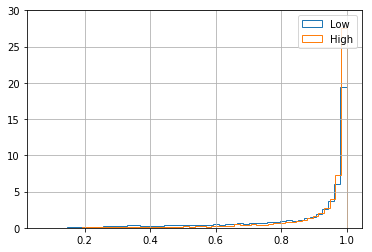

In [16]:
#plt.hist(y_pred[mass_test<409], weights=weights_test[mass_test<409], bins=50, histtype="step", normed=1, label="Low")
#plt.hist(y_pred[mass_test>=409], weights=weights_test[mass_test>=409], bins=50, histtype="step", normed=1, label="High")
plt.hist(y_pred[mass_test<409], bins=50, histtype="step", normed=1, label="Low")
plt.hist(y_pred[mass_test>=409], bins=50, histtype="step", normed=1, label="High")


plt.ylim(0, 30)
plt.legend()
plt.grid()
plt.show()

In [17]:
from scipy.stats import pearsonr
corr = pearsonr(mass_test, y_pred.ravel())
print "Unweighted correlation with mass is", corr

Unweighted correlation with mass is (0.14981696, 1.1130920531550135e-120)


In [ ]:
# now first put weights or itll just get all vbf correct

In [18]:
(y_pred>0.5).sum()/float(y_pred.shape[0])

0.93156953284246435

In [ ]:
# train with weights
# train with equalized weights
# shuffle dataset